In [1]:
import torch
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
UNET = True
CKPT_DIR = "/media/hdd/viscent/SR-UNet/experiments/output_vanilla_1024_t1/checkpoints/fold_0/199.pth"
OUTPUT_ROOT = "/media/hdd/viscent/SR-UNet/inference"
OUTPUT_PREFIX = input("UNet File prefix: ")
OUTPUT_PREFIX = os.path.join(OUTPUT_ROOT,OUTPUT_PREFIX)


if not UNET:
    model = BUNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
            latent_size=1024,
            alpha=0.00025,
            )
else:
    model = UNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
    )
ckpt = torch.load(CKPT_DIR)
if ckpt.get('model') is None:
    state_dict = ckpt['state_dict']
    _state_dict = {}
    for key in state_dict.keys():
        _state_dict[key.replace("model.","")] = state_dict[key]
    model.load_state_dict(_state_dict)
else:
    model.load_state_dict(ckpt["model"])

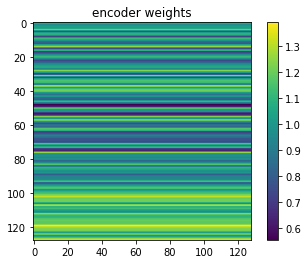

<Figure size 432x288 with 0 Axes>

In [3]:
encoder_weights = next(model.encoders[-1].parameters())
encoder_weights = encoder_weights.cpu().detach().numpy()
encoder_weights= np.expand_dims(encoder_weights,axis=1)
encoder_weights = np.repeat(encoder_weights, 128, axis=1)
if not UNET:
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(encoder_weights)
    ax1.set_title("encoder weights")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax, orientation="vertical")

    latent_weights = next(model.mu.parameters())
    latent_weights = latent_weights.cpu().detach().numpy()
    latent_weights = np.repeat(latent_weights, 128, axis=1)

    im2 = ax2.imshow(encoder_weights)
    ax2.set_title("latent weights")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax, orientation="vertical")
    fig.show()
else:
    fig = plt.imshow(encoder_weights)
    plt.title("encoder weights")
    plt.colorbar()
    plt.show()
plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

In [4]:
image = sitk.ReadImage("/media/hdd/viscent/SR-UNet/inference/unet_image.nii")
target = sitk.ReadImage("/media/hdd/viscent/SR-UNet/inference/unet_target.nii")
image_array = sitk.GetArrayFromImage(image)
target_array = sitk.GetArrayFromImage(target)
image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)
target_tensor = torch.tensor(target_array).unsqueeze(0).unsqueeze(0)

In [5]:
torch.cuda.set_device(0)
model.cuda()
model.train()
image_tensor = image_tensor.cuda()
target_tensor = target_tensor.cuda()
output = model(image_tensor)


In [6]:
im = image_tensor
im_hat=target_tensor
mse = torch.nn.MSELoss()(im, im_hat)
print('mse:', mse.cpu().detach().numpy())
if not UNET:
    mu, logvar = model.enc_mu, model.enc_logvar
    kl = 0.5 * (logvar.exp() + mu**2 - 1 - logvar)
    kl = torch.sum(kl)
    FE_simple = mse + 0.00025 * kl
    print('kl:', kl.cpu().detach().numpy())
    print('Free energy:', FE_simple.cpu().detach().numpy())

mse: 0.0060325894


In [7]:
output_array = output.cpu().detach().numpy()
output_image=sitk.GetImageFromArray(output_array)
sitk.WriteImage(output_image,OUTPUT_PREFIX+"_output.nii.gz")

Image


Text(0.5, 1.0, 'Image')

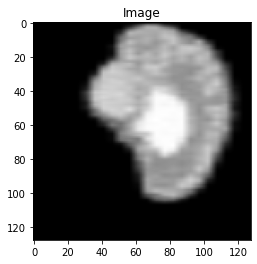

In [8]:
print("Image")
plt.imshow(image_array[40,...],cmap='gray')
plt.title("Image")

Output


Text(0.5, 1.0, 'Output')

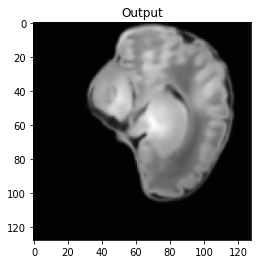

In [9]:
print("Output")
plt.imshow(output_array[0,0,40,...],cmap='gray')
plt.title("Output")

Target


Text(0.5, 1.0, 'Target')

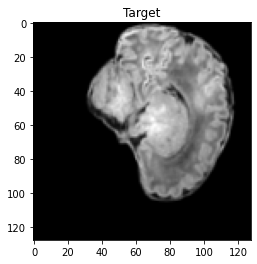

In [10]:
print("Target")
plt.imshow(target_array[40,...],cmap='gray')
plt.title("Target")

In [11]:
# for encoder in model.encoders:
#     for param in encoder.parameters():
#         param.requires_grad = False
#         param.fill_(0)
# for decoder in model.decoders:
#     for param in decoder.parameters():
#         param.requires_grad = False
#         param.fill_(0)

Output latent=0


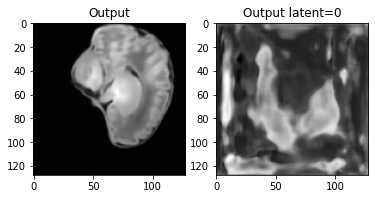

In [12]:
if not UNET:
    for param in model.mu.parameters():
        param.requires_grad = False
        param.fill_(0)
    output_0mu = model(image_tensor)
    output_0mu_array = output_0mu.cpu().detach().numpy()
    output_0mu_image=sitk.GetImageFromArray(output_0mu_array)
    print("Output μ=0")
    
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0mu_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output μ=0")
else:
    for param in model.encoders[0].parameters():
        param.requires_grad = False
        param.fill_(0)
    output_0latent = model(image_tensor)
    output_0latent_array = output_0latent.cpu().detach().numpy()
    output_0latent_image=sitk.GetImageFromArray(output_0latent_array)
    print("Output latent=0")

    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0latent_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output latent=0")
plt.savefig(OUTPUT_PREFIX+"_output.png")

In [13]:
UNET = False
CKPT_DIR = "/media/hdd/viscent/SR-UNet/experiments/output_vae_1024_t1/checkpoints/fold_0/199.pth"
OUTPUT_ROOT = "/media/hdd/viscent/SR-UNet/inference"
OUTPUT_PREFIX = input("B-UNet File prefix: ")
OUTPUT_PREFIX = os.path.join(OUTPUT_ROOT,OUTPUT_PREFIX)

if not UNET:
    model = BUNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
            latent_size=1024,
            alpha=0.00025,
            )
else:
    model = UNet3D(in_channels=1,
            out_channels=1,
            f_maps=[16, 32, 64, 128, 256],
            layer_order='gcr',
            num_groups=8,
            is_segmentation=False,
    )
ckpt = torch.load(CKPT_DIR)
if ckpt.get('model') is None:
    state_dict = ckpt['state_dict']
    _state_dict = {}
    for key in state_dict.keys():
        _state_dict[key.replace("model.","")] = state_dict[key]
    model.load_state_dict(_state_dict)
else:
    model.load_state_dict(ckpt["model"])

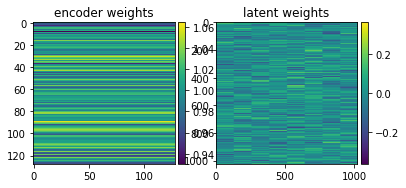

In [14]:
encoder_weights = next(model.encoders[-1].parameters())
encoder_weights = encoder_weights.cpu().detach().numpy()
encoder_weights= np.expand_dims(encoder_weights,axis=1)
encoder_weights = np.repeat(encoder_weights, 128, axis=1)
if not UNET:
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(encoder_weights)
    ax1.set_title("encoder weights")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im1, cax=cax, orientation="vertical")

    latent_weights = next(model.mu.parameters())
    latent_weights = latent_weights.cpu().detach().numpy()
    latent_weights = np.repeat(latent_weights, 128, axis=1)

    im2 = ax2.imshow(latent_weights)
    ax2.set_title("latent weights")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax, orientation="vertical")
    fig.show()
else:
    fig = plt.imshow(encoder_weights)
    plt.title("encoder weights")
    plt.colorbar()
    plt.show()
plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

In [15]:
image = sitk.ReadImage("/media/hdd/viscent/SR-UNet/inference/unet_image.nii")
target = sitk.ReadImage("/media/hdd/viscent/SR-UNet/inference/unet_target.nii")
image_array = sitk.GetArrayFromImage(image)
target_array = sitk.GetArrayFromImage(target)
image_tensor = torch.tensor(image_array).unsqueeze(0).unsqueeze(0)
target_tensor = torch.tensor(target_array).unsqueeze(0).unsqueeze(0)

In [16]:
torch.cuda.set_device(0)
model.cuda()
model.train()
image_tensor = image_tensor.cuda()
target_tensor = target_tensor.cuda()
output = model(image_tensor)


In [17]:
im = image_tensor
im_hat=target_tensor
mse = torch.nn.MSELoss()(im, im_hat)
print('mse:', mse.cpu().detach().numpy())
if not UNET:
    mu, logvar = model.enc_mu, model.enc_logvar
    kl = 0.5 * (logvar.exp() + mu**2 - 1 - logvar)
    kl = torch.sum(kl)
    FE_simple = mse + 0.00025 * kl
    print('kl:', kl.cpu().detach().numpy())
    print('Free energy:', FE_simple.cpu().detach().numpy())

mse: 0.0060325894
kl: 0.47543883
Free energy: 0.006151449


In [18]:
output_array = output.cpu().detach().numpy()
output_image=sitk.GetImageFromArray(output_array)
sitk.WriteImage(output_image,OUTPUT_PREFIX+"_output.nii")

Image


Text(0.5, 1.0, 'Image')

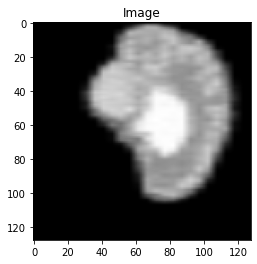

In [19]:
print("Image")
plt.imshow(image_array[40,...],cmap='gray')
plt.title("Image")

Output


Text(0.5, 1.0, 'Output')

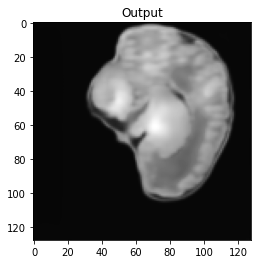

In [20]:
print("Output")
plt.imshow(output_array[0,0,40,...],cmap='gray')
plt.title("Output")

Target


Text(0.5, 1.0, 'Target')

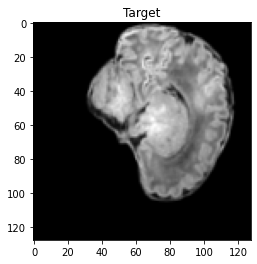

In [21]:
print("Target")
plt.imshow(target_array[40,...],cmap='gray')
plt.title("Target")

In [22]:
# for encoder in model.encoders:
#     for param in encoder.parameters():
#         param.requires_grad = False
#         param.fill_(0)
# for decoder in model.decoders:
#     for param in decoder.parameters():
#         param.requires_grad = False
#         param.fill_(0)

Output μ=0


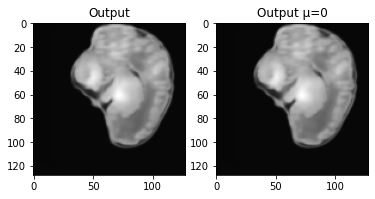

In [23]:
if not UNET:
    for param in model.mu.parameters():
        param.requires_grad = False
        param.fill_(0)
    output_0mu = model(image_tensor)
    output_0mu_array = output_0mu.cpu().detach().numpy()
    output_0mu_image=sitk.GetImageFromArray(output_0mu_array)
    print("Output μ=0")
    
    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0mu_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output μ=0")
else:
    for param in model.encoders[0].parameters():
        param.requires_grad = False
        param.fill_(1)
    output_0latent = model(image_tensor)
    output_0latent_array = output_0latent.cpu().detach().numpy()
    output_0latent_image=sitk.GetImageFromArray(output_0latent_array)
    print("Output latent=0")

    fig,(ax1,ax2) = plt.subplots(1,2)
    im1 = ax1.imshow(output_array[0,0,40,...],cmap='gray')
    ax1.set_title("Output")

    im2 = ax2.imshow(output_0latent_array[0,0,40,...],cmap='gray')
    ax2.set_title("Output latent=0")
plt.savefig(OUTPUT_PREFIX+"_output_0.png")